In [1]:
#restart the kernel if switching from inline to notebook
import matplotlib.pyplot as plt
%matplotlib notebook 
plt.style.use('seaborn-whitegrid')
import corner

import numpy as np
import numpy.linalg
import scipy.stats
from scipy.signal import argrelextrema
import pandas as pd

import emcee
import george

from subsample import subsample # daniela's code
from emcee_utils import walker_params, plot_gpfit
#from plotting import plot_steps
from plotting import plot_lightcurve, plot_folded_lightcurve, plot_mcmc_sampling_results, plot_steps

In [2]:
txt = "5318.csv"
data = pd.read_csv(txt, delimiter=',')

tsample = data.mjd
fsample = data.magcorrOO
flux_err = data.sigmapsf

In [3]:
data.head()

,Unnamed: 0,objectId,jd,fid,pid,diffmaglim,programid,candid,isdiffpos,tblid,...,exptime,obsdate,mjd,magcorrZTF,magOO,phaseangle,heliodist,geodist,velocity,magcorrOO
0,618257,ZTF18acanzmr,2.458398e+06,1,643478173315,20.7072,1,643478173315015003,t,3,...,30.0,2018-10-06T11:28:34.000,58397.477743,0.0332,18.202296,25.331173,2.285977,1.858844,0.208733,-0.369096
1,656040,ZTF18acbyomy,2.458424e+06,2,669380334015,20.4425,1,669380334015015035,t,35,...,30.0,2018-11-01T09:07:40.996,58423.379907,-0.2224,17.108835,21.461197,2.246522,1.534311,0.041417,-0.131235
2,658941,ZTF18acbzdlm,2.458424e+06,1,669411824015,20.0388,1,669411824015015017,t,17,...,30.0,2018-11-01T09:53:02.000,58423.411400,1.1469,17.629764,21.453295,2.246474,1.533948,0.040351,0.717136
3,703432,ZTF18acecblq,2.458429e+06,1,674338714015,20.7330,1,674338714015015013,t,13,...,30.0,2018-11-06T08:07:45.002,58428.338287,0.3085,17.502880,20.152149,2.238955,1.479159,0.005558,-0.094380
4,713892,ZTF18acclmmm,2.458426e+06,1,671398284015,20.5974,1,671398284015015056,t,56,...,30.0,2018-11-03T09:33:31.997,58425.397859,0.3574,17.579274,20.953106,2.243442,1.511496,0.024840,-0.021874


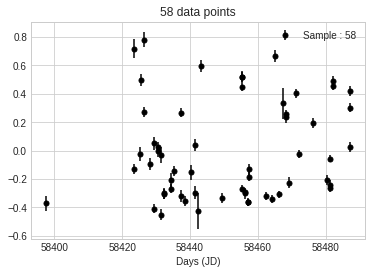

In [4]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.set_title("%i data points"%(len(fsample)))
ax.set_xlabel("Days (JD)")
ax.errorbar(tsample, fsample, yerr=flux_err, fmt="o", markersize=5,
            color="black", zorder=10, 
            label="Sample : " + str(len(tsample)))
ax.legend()

In [5]:
def prior(params):

    """
    Calculated the log of the prior values, given parameter values.

    Parameters
    ----------
    params : list
        List of all kernel parameters

    param[0] : float
        mean (between 0 and 2)

    param[1] : float
        log amplitude (between -10 and 10)

    param[2] : float
        gamma (log gamma between 0.1 and 40)

    param[3] : float
        log period (period between 1h and 24hrs)

    Returns
    -------
    sum_log_prior : int
        sum of all log priors (-inf if a parameter is out of range)

    """

    p_mean = scipy.stats.norm(1, 0.5).logpdf(params[0])
    #p_log_amp = scipy.stats.uniform(-10,30).logpdf(params[1])
    p_log_amp = scipy.stats.norm(np.log(0.15), np.log(2)).logpdf(params[1])
    p_log_gamma = scipy.stats.norm(np.log(10), np.log(2)).logpdf(np.log(params[2]))
    ###print this line to get the prob value: p_log_gamma = scipy.stats.norm(np.log(10), np.log(2)).logpdf(np.log(params[2]))
    p_period = scipy.stats.uniform(np.log(1./24.), -np.log(1./24.)).logpdf(params[3])
    #p_period = scipy.stats.halfcauchy(loc=np.log(0.5/24.), scale=np.exp(2./24.)).logpdf(params[3])

    sum_log_prior =  p_mean + p_log_amp + p_log_gamma + p_period

    if np.isnan(sum_log_prior) == True:
        return -np.inf

    return sum_log_prior

def logl(params, gp, tsample, fsample, flux_err):
    # compute lnlikelihood based on given parameters
    gp.set_parameter_vector(params)

    try:
        gp.compute(tsample, flux_err)
        lnlike = gp.lnlikelihood(fsample)
    except np.linalg.LinAlgError:
        lnlike = -1e25
    return lnlike

def post_lnlikelihood(params, gp, tsample, fsample, flux_err):

    """
    Calculates the posterior likelihood from the log prior and
    log likelihood.

    Parameters
    ----------
    params : list
        List of all kernel parameters

    Returns
    -------
    ln_likelihood : float
        The posterior, unless the posterior is infinite, in which case,
        -1e25 will be returned instead.

    """

    # calculate the log_prior
    log_prior = prior(params)

    # return -inf if parameters are outside the priors
    if np.isneginf(log_prior) == True:
        return -np.inf

    try:
        lnlike = logl(params, gp, tsample, fsample, flux_err)
        ln_likelihood = lnlike+log_prior

    except np.linalg.linalg.LinAlgError:
        ln_likelihood = -1e25

    return ln_likelihood if np.isfinite(ln_likelihood) else -1e25

In [6]:
ndim, nwalkers = 4, 100

In [7]:
# initialize walker parameters
gp_mean = np.mean(fsample)
log_amp = np.log(fsample.max()-fsample.min())
gamma = 1
log_period = np.log(0.5)

params = [np.mean(fsample), log_amp, gamma, log_period]

# set up gp kernel
kernel = np.exp(log_amp) * george.kernels.ExpSine2Kernel(gamma = gamma, log_period = log_period)
gp = george.GP(kernel, fit_mean=True, mean=gp_mean)
gp.compute(tsample, flux_err)

# equally distributed starting period values
p_start = np.array(params)/100.
cov_matrix = np.sqrt(np.diag(p_start)**2)
p0 = np.random.multivariate_normal(mean=params, cov=cov_matrix, size=(nwalkers))
x = np.log(np.linspace(2,12,nwalkers)/24.)
p0[:,3] = x


In [8]:
threads=1
sampler = emcee.EnsembleSampler(nwalkers, ndim, post_lnlikelihood, args=[gp, tsample, fsample, flux_err], threads=threads)

In [9]:
%%time
mcmc_sampling = sampler.run_mcmc(p0, 100)

/home/christina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log


CPU times: user 33 s, sys: 130 ms, total: 33.1 s
Wall time: 33.1 s


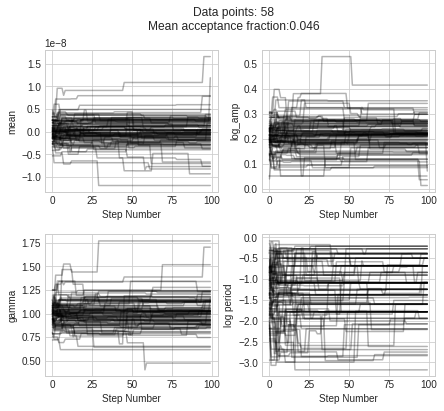

In [10]:
plot_steps(sampler, dims = ['mean', 'log_amp', 'gamma', 'log period'], p0=[params], data_pts=len(fsample))

Text(0.5,0,'Period (hours)')

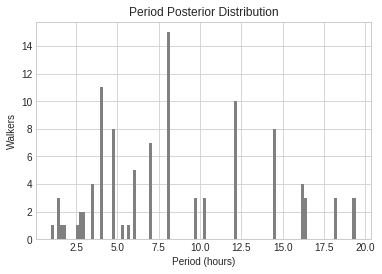

In [15]:
# sampler.chain[chain, step, dimension]
end_period = sampler.chain[:,-1,-1]
end_period.sort()

fig, fx = plt.subplots(1,1)
fx.hist(np.exp(end_period)*24., bins=100, color='grey')
fx.set_title('Period Posterior Distribution')
fx.set_ylabel('Walkers')
fx.set_xlabel('Period (hours)')

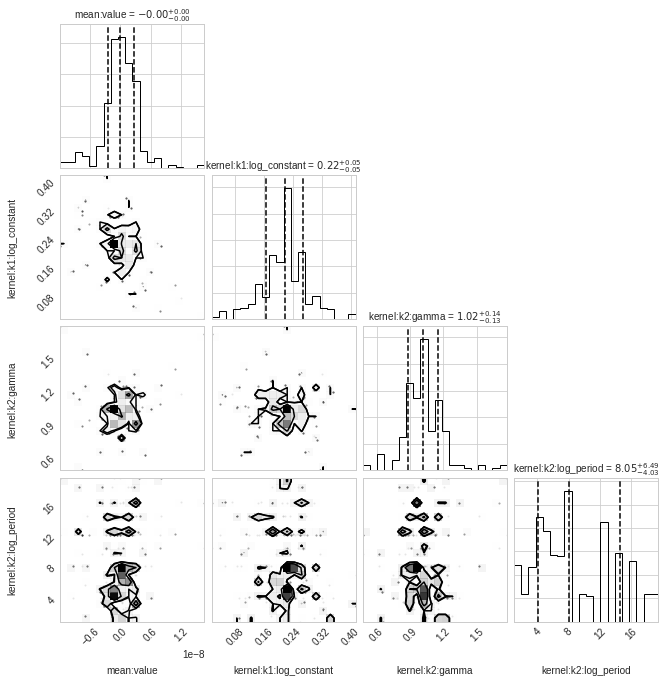

In [37]:
# make some labels
labels = list(gp.get_parameter_names())
#labels[3] = 'period'

# percentage of steps to plot
percent = 0.1

# generate list of last steps spanning backwards
x = list(range(-1,-int(sampler.iterations*percent)-1,-1))

# only plot x last steps
# reshape into 2d array instead of 3d
#sampler.chain[walker, step, param]
figure = corner.corner(sampler.chain[:,x,:].reshape(int(sampler.iterations*percent*sampler.k),4), 
                       labels=labels, quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 10})

The distribution of periods ended up looking like this.

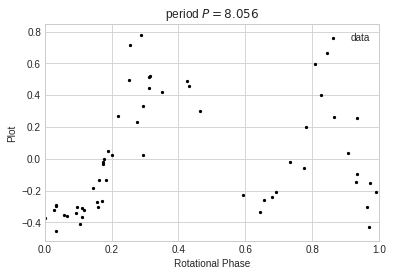

In [27]:
periods = np.exp(sampler.chain[:,-1,-1])
best_period = np.median(periods)
plot_folded_lightcurve(tsample, fsample, np.log(best_period)/24.)

We can now see how the different posterior distributions model the original sampled data. Feel free to give the file names **namestr** an appropriate title.

In [ ]:
def save_chain(file_name, sampler):
        header = str(sampler.chain.shape)
        np.savetxt(file_name, sampler.flatchain, header=header)
        return

filename = "5318_new_priors"

save_chain(filename + "_results.txt", sampler)

[-2.28779141e-09  2.67179451e-01  8.08731600e-01 -1.24663603e+00]
[-8.79538106e-10  2.72649724e-01  8.76288412e-01 -2.85462521e+00]
[-2.90792869e-09  2.86311363e-01  1.01627062e+00 -2.76735646e+00]
[ 1.80432461e-09  3.54870285e-01  1.14757939e+00 -2.73259610e+00]
[-4.35146707e-10  2.50565766e-01  8.89886153e-01 -1.07984266e+00]
[ 2.48530455e-09  5.07855280e-02  1.14692589e+00 -3.87307827e-01]
[ 2.97355477e-09  1.10043519e-01  1.06706124e+00 -1.37180453e+00]
[-1.78923641e-09  1.80383926e-01  9.25772360e-01 -1.04005955e+00]
[ 3.27611486e-09  1.93670529e-01  9.86435959e-01 -1.27021393e+00]
[ 1.08380699e-09  1.75264474e-01  1.12214252e+00 -1.95497526e+00]


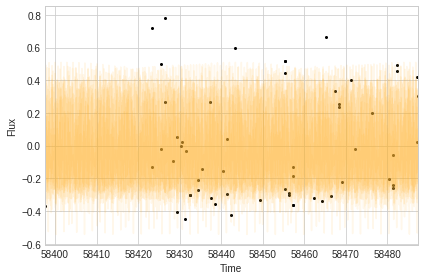

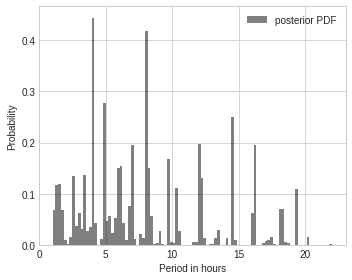

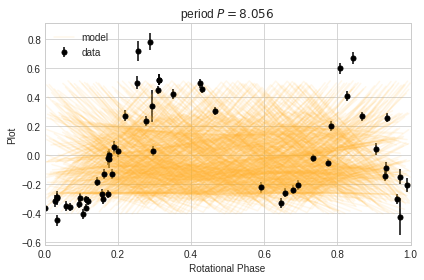

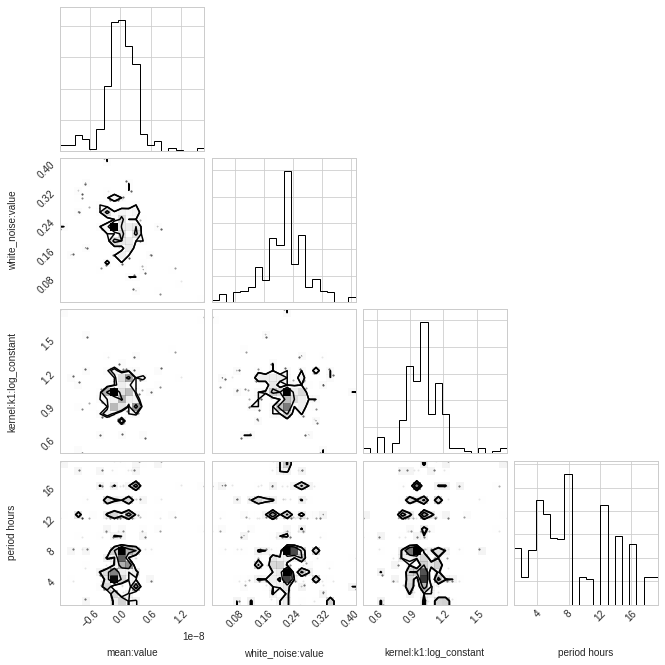

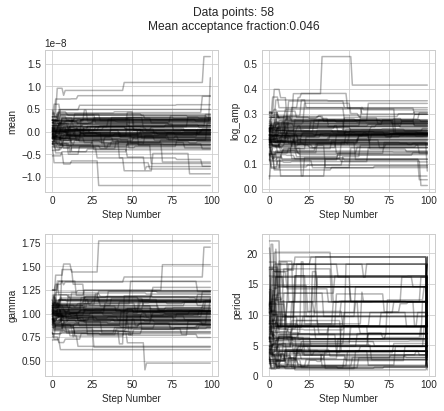

In [18]:
plot_mcmc_sampling_results(np.array(tsample), fsample, flux_err, gp, sampler, 
                           namestr="test" + "_plots", true_lightcurve=None, 
                           true_period=None)